In [1]:
import time
start_time=time.time()

In [2]:
import sys
from pathlib import Path
import json
import numpy as np
import strucfunc
import matplotlib.pyplot as plt
import time
from astropy.io import fits
import pandas as pd
import seaborn as sns
import math
import sys
import os
from sabreMod import sosf,sosfh
from scipy import interpolate
import itertools
import lmfit


plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="20"

604

In [3]:
Sample='604'

samples=pd.read_csv('SampleList//'+Sample+'.csv',header=None)

N1N=dict()
N1=dict()


for i in range(len(samples)):
    N1N[i]=samples[0][i]
    
for i in range(len(samples)):
    N1[i]=pd.read_csv('SFdata//'+N1N[i]+'.csv')    

samples

,0
0,1997MT604
1,2019Mk604


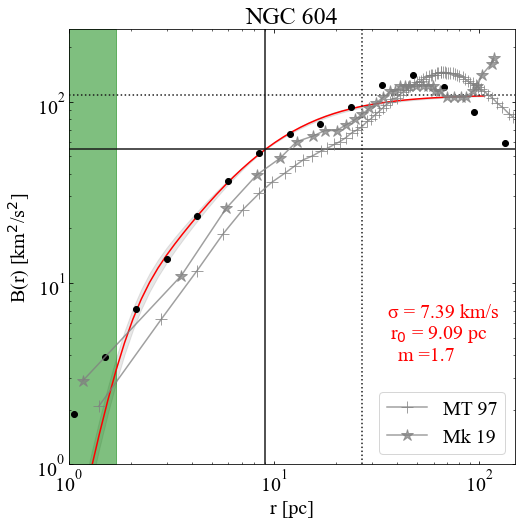

In [4]:
def bfunc(r, r0, sig2, m, s0):
    "Theoretical structure function"
    C = 1.0 / (1.0 + (r/r0)**m)
    a = (np.tanh((r/s0)**2))**2
    return 2.0*a*sig2*(1 - C)

data = json.load(open("SFdata//604.json"))

sns.set_color_codes()
fig, ax = plt.subplots(figsize=(8, 8))


pixscale = 0.26 # arcsec
pixscale *= 4.09              # parsec
r = pixscale * 10**np.array(data["log10 r"])
B = np.array(data["Unweighted B(r)"])
sig2 = data["Unweighted sigma^2"]
B_w = np.array(data["Weighted B(r)"])
sig2_w = data["Weighted sigma^2"]

# Plot fit to unweighted strucfunc
rgrid = pixscale * np.logspace(0.0, 2)
r0 = np.interp(sig2, B, r)
#r2 = np.interp((2*sig2), B, r)
m = 1.7
s0 = 4.09/2.355                    # parsec
flabel = rf"$m = {m:.2f}$, $r_0 = {r0:.1f}$ pc, $\sigma^2 = {sig2:.0f}$ (km/s)$^2$"
ax.fill_between(
    rgrid,
    bfunc(rgrid, r0,sig2, m - 0.1, s0),
    bfunc(rgrid, r0,sig2, m + 0.1, s0),
    color="k", alpha=0.1,
)
ax.plot(rgrid, bfunc(rgrid, r0, sig2, m, s0), color="red")

# Plot points from unweighted strucfunc
ax.plot(r, B, 'o',  color='black')

ax.axhline(sig2, color="k", ls="-")
ax.axvline(x=r0, color='k', linestyle='-')

ax.axhline(2*sig2, color="k", ls=":")
ax.axvline(x=27, color='k', linestyle=':')


ax.set(
    xscale = "log",
    yscale = "log",
    ylim  = [1, 250],
    xlim  = [1, 150],
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
)


ax.text(0.8, 0.25,'m ='+str(m), ha='center', va='center', transform=ax.transAxes, color='red')
ax.text(0.83, 0.30,'r$_{0}$ = '+str(np.round(r0,2))+' pc', ha='center', va='center', transform=ax.transAxes, color='red')
ax.text(0.84, 0.35,'σ = ' +str(np.round(sig2**(0.5),2)) + ' km/s', ha='center', va='center', transform=ax.transAxes, color='red')

plt.loglog(N1[0].pc,N1[0].S,marker='+',color="gray",alpha=0.75,label="MT 97",markersize="12")
plt.loglog(N1[1].pc,N1[1].S,marker='*',color="gray",alpha=0.75,label="Mk 19",markersize="12")


plt.title('NGC 604')

xs=np.linspace(1,4/2.355  ,10)
ys=np.linspace(1,4,10)

ax.fill_between(xs, 0, 1, where=ys > 0.5,
                color='green', alpha=0.5, transform=ax.get_xaxis_transform())

plt.tick_params(which='both', labelright=False, direction='in', right=True,  top=True)


#fig.tight_layout()
#sns.despine()

plt.legend()
plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="21"


fig.savefig('SFplots//604.pdf', bbox_inches='tight')

In [5]:
r.max()/r0

14.725062749295018

In [6]:
r

array([  1.0634    ,   1.50209242,   2.12176195,   2.99706841,
         4.23347165,   5.97993765,   8.44688645,  11.93154424,
        16.85375421,  23.80656059,  33.62766064,  47.50033319,
        67.09600401,  94.77562476, 133.87412829])

In [7]:
B

array([  1.9057852 ,   3.90697386,   7.22286646,  13.48128552,
        23.47866655,  36.72422086,  52.04679308,  65.95774045,
        75.41742209,  93.83361035, 123.03824318, 140.89454558,
       120.49165553,  87.17814977,  59.48587133])

In [8]:
x=np.log10(r)
y=np.log10(B)

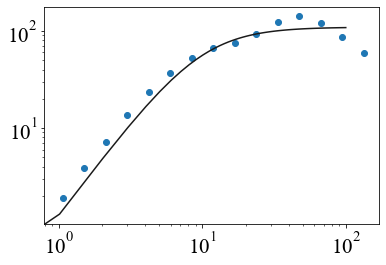

In [9]:
plt.scatter(r,B)


lo=9.74
n=1.95
xx=np.linspace(0,100,100)
c=1/(1+(xx/lo)**n)
yy=2*(1-c)*sig2

plt.loglog(xx,yy,color='k', linestyle='-')

In [10]:
pars = lmfit.Parameters()
pars.add_many(('a', 9.09), ('b', 1.7))
def residual(p):
    C=1.0 / (1.0 + (r/(p['a'])**p['b']))
    return 2.0*sig2*(1 - C)- B

In [11]:
mini = lmfit.Minimizer(residual, pars)
result = mini.minimize()
print(lmfit.fit_report(result.params))

[[Variables]]
    a:  10.0830042 +/- 1.6875e+08 (1673586511.03%) (init = 9.09)
    b:  0.91722102 +/- 6720620.60 (732715499.68%) (init = 1.7)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) = -1.000


In [12]:
pars = lmfit.Parameters()
pars.add_many(('a', 9.09), ('b', 1.7))
def residual(p):
    C=1.0 / (1.0 + (x/(p['a'])**p['b']))
    return 2.0*sig2*(1 - C)- y

In [13]:
mini = lmfit.Minimizer(residual, pars)
result = mini.minimize()
print(lmfit.fit_report(result.params))

[[Variables]]
    a:  9.74841242 +/- 2373720.17 (24349812.74%) (init = 9.09)
    b:  1.95107815 +/- 208635.085 (10693322.81%) (init = 1.7)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) = -1.000


In [14]:
ci = lmfit.conf_interval(mini, result)
lmfit.printfuncs.report_ci(ci)

      99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a:      -inf      -inf      -inf   9.74841      +inf      +inf      +inf
 b:      -inf      -inf      -inf   1.95108      +inf      +inf      +inf


C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a=7.798729938437276) = 0.0 < max(sigmas).
  warn(errmsg)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a=11.698094907655914) = 0.0 < max(sigmas).
  warn(errmsg)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(b=1.5608625223636339) = 0.0 < max(sigmas).
  warn(errmsg)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(b=2.341293783545451) = 0.0 < max(sigmas).
  warn(errmsg)


In [15]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 42.845255851745605 seconds ---
